# Enhancing Image Classification Precision Through TensorFlow and Data Augmentation Strategies

Data augmentation is a technique that applies random transformations to images, such as flipping, rotation, cropping, brightness, contrast, and hue, to create more diverse and realistic variations of the original images. Data augmentation can enhance the quality and quantity of training data, which are crucial for developing better deep learning models. By simulating the real-world scenarios that the model may encounter, data augmentation can help the model learn more general and resilient features, and avoid overfitting to the training data. Data augmentation can also reduce the need for collecting and labeling more data, which can be costly and time-consuming {cite:p}`mikolajczyk2018data, shorten2019survey, dastour2023comparison`.

TensorFlow is a popular framework for developing and deploying deep learning models, and it provides a rich set of functions for image processing and data augmentation. The `tf.image` module contains many functions that can apply random transformations to images, with a specified probability of applying the transformation. These functions take an image tensor as input and return a transformed image tensor as output. By applying these functions sequentially, one can create a pipeline of data augmentations that can enrich the dataset and improve the model's generalization and robustness {cite:p}`TensorFlowDocumentation`.

## Dataset

The [Fire Dataset](https://www.kaggle.com/datasets/phylake1337/fire-dataset) is a collection of images that can be used to train a machine learning model to distinguish between fire and non-fire scenes. The dataset consists of two folders: "fire_images" and "non-fire_images". The "fire_images" folder contains 755 images of outdoor fire events, some of which have a lot of smoke. The "non-fire_images" folder has 244 images of various natural scenes, such as forests, rivers, animals, and waterfalls.

The dataset poses a binary classification problem, where the model has to predict whether an image belongs to the fire or non-fire class. However, the dataset is imbalanced, meaning that there are more fire images than non-fire images. This can cause the model to be biased towards the fire class and perform poorly on the non-fire class. To prevent this, it is recommended to create a balanced validation set, where the number of images from each class is equal. For example, one can randomly select 40 images from each class and use them as the validation set, while the remaining images can be used as the training set. This way, the model can be evaluated fairly and accurately on both classes.

<!-- from google.colab import drive
drive.mount('/content/drive') -->

In [2]:
import os
import numpy as np

class DatasetLabeler:
    def __init__(self, dataset_path, extension='.png'):
        """
        Initializes the DatasetLabeler object.

        Parameters:
        - dataset_path (str): The path to the dataset.
        - extension (str): The file extension to filter files in the dataset (default is '.png').
        """
        self.dataset_path = dataset_path
        self.extension = extension
        self.files_dict = self._generate_files_dict()
        self.subdirectories = list(self.files_dict.keys())
        self.labels_dict = self._generate_labels_dict()
        self.num2label_dict = self._generate_num2label_dict()

    def _generate_files_dict(self):
        """
        Generates a dictionary representing the directory structure and associated files in the dataset.

        Returns:
        - dict: A dictionary with subdirectory names as keys and lists of associated files as values.
        """
        out = {}
        sep = ' ' * 3
        title = os.path.basename(self.dataset_path)

        print('=' * (len(title) + 1))
        print(title + ':')
        print('=' * (len(title) + 1))

        for entry in os.listdir(self.dataset_path):
            entry_path = os.path.join(self.dataset_path, entry)
            if os.path.isdir(entry_path):
                print('└──', entry + ':')

                sub = os.path.join(self.dataset_path, entry)
                file_list = [x for x in os.listdir(sub) if x.endswith(self.extension)]
                out[entry] = file_list

                print(2 * sep, f'{len(file_list)} {file_list[0].split(".")[-1].upper()} files:')
                print(2 * sep, ', '.join(file_list[:5]) + ', ...')

        return out

    def _generate_labels_dict(self):
        """
        Generates a dictionary mapping modified subdirectory names to original names.

        Returns:
        - dict: A dictionary with modified subdirectory names as keys and original names as values.
        """
        return dict(zip(self.subdirectories, [x.replace('_images','')\
                                              .replace('_',' ').title()\
                                              .replace('Non ','Non-') for x in self.subdirectories]))

    def _generate_num2label_dict(self):
        """
        Generates a dictionary mapping numerical labels to modified subdirectory names.

        Returns:
        - dict: A dictionary with numerical labels as keys and modified subdirectory names as values.
        """
        n = len(self.labels_dict.values())
        return dict(zip(np.arange(n), self.labels_dict.values()))

# Example usage:
dataset_path = 'fire_dataset'
labeler = DatasetLabeler(dataset_path)

# Create a dictionary mapping modified subdirectory names to original names
labels_dict = labeler.labels_dict

# Create a dictionary mapping numerical labels to modified subdirectory names
num2label_dict = labeler.num2label_dict

fire_dataset:
└── fire_images:
       755 PNG files:
       fire.10.png, fire.1.png, fire.100.png, fire.102.png, fire.103.png, ...
└── non_fire_images:
       244 PNG files:
       non_fire.1.png, non_fire.102.png, non_fire.104.png, non_fire.100.png, non_fire.103.png, ...


The [Fire Dataset](https://www.kaggle.com/datasets/phylake1337/fire-dataset) contains images of fire and non-fire scenes, which are imbalanced in number. There are 755 fire images and 244 non-fire images, which means that the fire class has about 75.6% of the total images, while the non-fire class has only 24.4%. If we randomly split this data into train, validation and test sets, we might end up with sets that do not reflect the true distribution of the classes. For example, the test set might have too many fire images or too few non-fire images, which would affect the evaluation of the model's performance. To avoid this problem, we need to use stratified splitting, which ensures that each set has the same proportion of fire and non-fire images as the original data. This way, we can train and validate the model on balanced sets, and test it on a realistic set. Stratified splitting can be done using scikit-learn's StratifiedShuffleSplit function¹, which randomly shuffles and splits the data into n folds, while preserving the percentage of samples for each class.

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Define the batch size for loading data
batch_size = 128
random_seed = 0

# Define the image dimensions
Img_Height = 180
Img_Width = 180

# Define the path to the dataset folder
dataset_path = 'fire_dataset'

# Load the dataset using TensorFlow's image_dataset_from_directory
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dataset_path,
    seed = random_seed,
    image_size = (Img_Height, Img_Width),
    batch_size = batch_size,
    validation_split = None,
    subset = None)

# Extract images and labels from the dataset
X = []
y = []
for images, labels in full_ds:
    X.extend(images)
    y.extend(labels)

# Convert the extracted data to numpy arrays
X = np.array(X)
y = np.array(y)

# Use stratified sampling to split the data into training, validation, and test sets while preserving class ratios
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed, stratify=y_temp)

# Create TensorFlow datasets from the numpy arrays, batching the data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Display the number of samples in each split
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

Found 999 files belonging to 2 classes.
Number of training samples: 799
Number of validation samples: 100
Number of test samples: 100


Training Set Class Distribution (Percentage):
{'Fire': 75.59, 'Non-Fire': 24.41}

Validation Set Class Distribution (Percentage):
{'Fire': 75.0, 'Non-Fire': 25.0}

Test Set Class Distribution (Percentage):
{'Fire': 76.0, 'Non-Fire': 24.0}


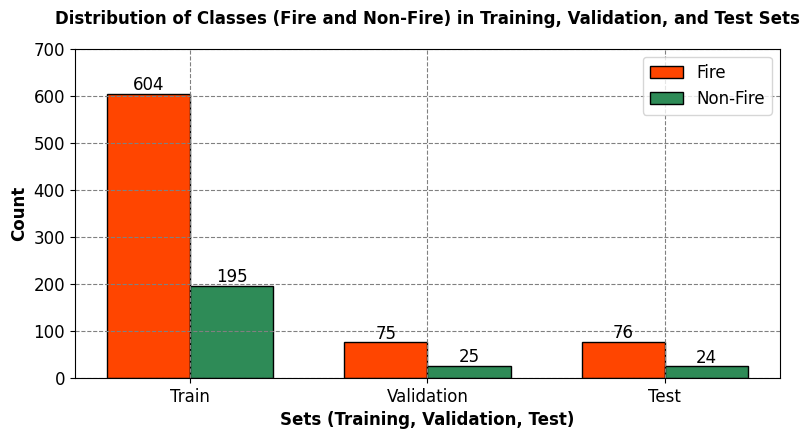

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('https://raw.githubusercontent.com/HatefDastour/ENGG_680/main/Files/mystyle.mplstyle')

def calculate_class_distribution(y, label_dict):
    """
    Calculate and return the class distribution of a given dataset.

    Parameters:
    - y (numpy array): Target labels of the dataset.
    - label_dict (dict): Mapping of class indices to class labels.

    Returns:
    - class_distribution (dict): Distribution of classes as percentages with labels.
    """
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_distribution = dict(zip([label_dict[i] for i in unique], [round(x / total_samples, 4) * 100 for x in counts]))
    return class_distribution

def print_bold(txt, color_code=35):
    """
    Display text in bold with optional color.

    Parameters:
    - txt (str): The text to be displayed.
    - color_code (int): ANSI color code for the text (default is 35 for purple).
    """
    print(f"\033[1;{color_code}m{txt}\033[0m")

# Calculate and display class distribution in each dataset as percentages with labels
print_bold("Training Set Class Distribution (Percentage):")
print(calculate_class_distribution(y_train, num2label_dict))

print_bold("\nValidation Set Class Distribution (Percentage):")
print(calculate_class_distribution(y_val, num2label_dict))

print_bold("\nTest Set Class Distribution (Percentage):")
print(calculate_class_distribution(y_test, num2label_dict))

# Count occurrences of 0s and 1s in each set
train_counts, val_counts, test_counts = np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4.5))

# Set up the bar positions and widths
bar_positions = np.arange(3)
bar_width = 0.35

# Create horizontal bars with custom colors
bars1 = ax.bar(bar_positions - bar_width / 2, [train_counts[0], val_counts[0],
                                               test_counts[0]], bar_width, color='OrangeRed', label='Fire', edgecolor='black')
bars2 = ax.bar(bar_positions + bar_width / 2, [train_counts[1], val_counts[1],
                                               test_counts[1]], bar_width, color='SeaGreen', label='Non-Fire', edgecolor='black')

# Set plot labels and title
ax.set_title('Distribution of Classes (Fire and Non-Fire) in Training, Validation, and Test Sets',
             weight='bold', fontsize=12, y = 1.05)
ax.set_xlabel('Sets (Training, Validation, Test)', weight='bold')
ax.set_ylabel('Count', weight='bold')
ax.set_ylim([0, 700])  # Adjust the y-axis limit as needed

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Train', 'Validation', 'Test'])

# Show the legend
ax.legend(fontsize = 12)

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval)}",
                ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()

The table below shows the number and percentage of fire and non-fire samples in each dataset split:

| Dataset Split | Number of Samples | Fire (%) | Non-Fire (%) |
|---------------|-------------------|----------|--------------|
| Training      | 799               | 75.59    | 24.41        |
| Validation    | 100               | 75.00    | 25.00        |
| Test          | 100               | 76.00    | 24.00        |

This shows the size and balance of each set, which are important for training, validating, and testing the model. A balanced class distribution helps the model generalize well for both classes.

## Creating a Model

The data_augmentation layer, implemented as a TensorFlow object, facilitates the application of random transformations to input images. These transformations encompass horizontal and vertical flipping, rotation, and contrast adjustment. The objective is to diversify the perspectives from which the model learns, thereby mitigating the risk of overfitting. A concise breakdown of the associated code follows:

1. Importing the TensorFlow library, which offers a comprehensive suite of tools and functions for machine learning.
2. Creation of a Sequential object, serving as a container for a sequence of layers applicable to input data.
3. Addition of a RandomFlip layer to the Sequential object, introducing random horizontal or vertical flips to input images. The input_shape parameter delineates the dimensions of the images as (Img_Height, Img_Width, 3), signifying height, width, and 3 color channels.
4. Inclusion of a RandomRotation layer to the Sequential object, enabling random rotation of input images by a factor of 0.1, corresponding to an angle range of -10 to 10 degrees.
5. Integration of a RandomContrast layer to the Sequential object, inducing random contrast adjustments to input images by a factor of 0.1, translating to a contrast range between 0.9 and 1.1 times the original contrast.

The data_augmentation layer, when applied to training dataset images, serves as a preprocessing step prior to model ingestion.

In [5]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal", input_shape=(Img_Height, Img_Width, 3)),
                                         tf.keras.layers.RandomRotation(0.1),
                                         tf.keras.layers.RandomContrast(0.1),
                                         ])

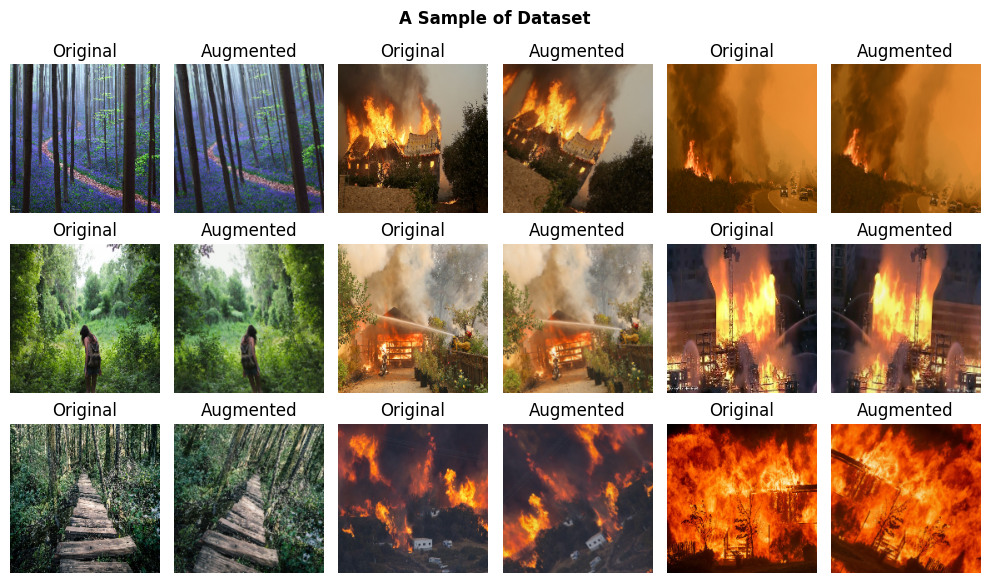

In [6]:
# Import matplotlib
import matplotlib.pyplot as plt

# Get some images and labels from your training dataset
images, labels = next(iter(train_ds))

# Apply the data_augmentation layer to the images
augmented_images = data_augmentation(images)

# Plot some of the original and augmented images
plt.figure(figsize=(10, 6))
for i in range(9):
  # Plot the original image
  ax = plt.subplot(3, 6, 2*i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title("Original")
  plt.axis("off")

  # Plot the augmented image
  ax = plt.subplot(3, 6, 2*i + 2)
  plt.imshow(augmented_images[i].numpy().astype("uint8"))
  plt.title("Augmented")
  plt.axis("off")

# Set a title for the entire figure
plt.suptitle('A Sample of Dataset', fontweight='bold', fontsize=12)
plt.tight_layout()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                               

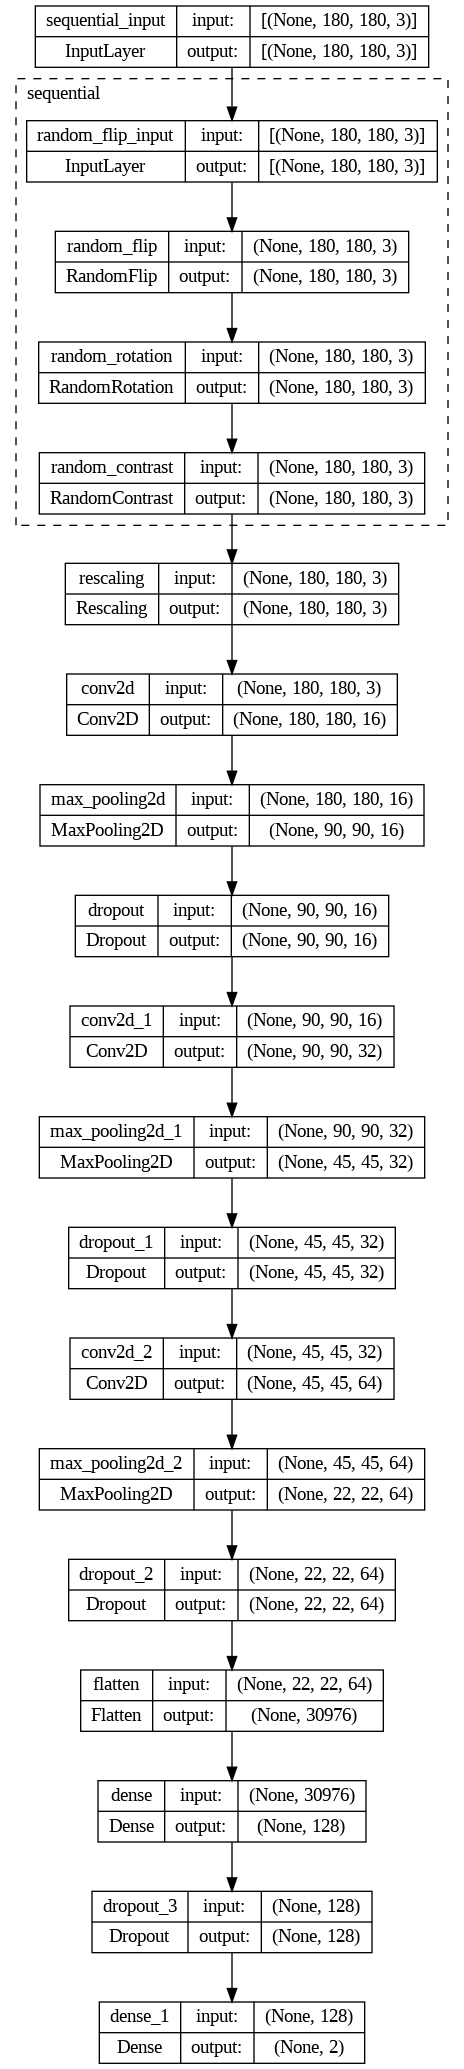

In [7]:
import tensorflow as tf

# Define and compile the model
model = tf.keras.models.Sequential(name = 'CNN', layers = [
    data_augmentation,
    # Rescaling layer: Normalize pixel values to the range [0, 1]
    tf.keras.layers.Rescaling(1./255, input_shape=(Img_Height, Img_Width, 3)),

    # First convolutional layer with 16 filters, each of size 3x3
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Max-pooling layer to reduce spatial dimensions
    tf.keras.layers.MaxPooling2D(),

    # Dropout layer to mitigate overfitting
    tf.keras.layers.Dropout(0.25),

    # Second convolutional layer with 32 filters, each of size 3x3
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Another max-pooling layer
    tf.keras.layers.MaxPooling2D(),

    # Dropout layer
    tf.keras.layers.Dropout(0.25),

    # Third convolutional layer with 64 filters, each of size 3x3
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Another max-pooling layer
    tf.keras.layers.MaxPooling2D(),

    # Dropout layer
    tf.keras.layers.Dropout(0.25),

    # Flatten layer to convert the 2D feature maps into a 1D vector
    tf.keras.layers.Flatten(),

    # Fully connected (dense) layer with 128 neurons and ReLU activation
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

    # Dropout layer
    tf.keras.layers.Dropout(0.5),

    # Output layer with 2 neurons (for binary classification) and no activation function
    tf.keras.layers.Dense(2)
])

# Display a summary of the model architecture
model.summary()

# Plot the model graph with layer shapes and names
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

The model is a convolutional neural network (CNN) that can classify images into two classes: fire and non-fire. The model consists of the following layers:

- A data_augmentation layer, which randomly transforms the input images by flipping, rotating, and changing contrast. This helps the model learn from diverse perspectives and avoid overfitting.
- A rescaling layer, which normalizes the pixel values of the input images from the range [0, 255] to the range [0, 1]. This makes the input data easier for the model to learn.
- A convolutional layer, which applies 16 filters of size (3, 3) with relu activation to the input images to extract features such as edges, shapes, and textures. The output of this layer is a feature map, which is a representation of the input image in terms of the detected features.
- A max pooling layer, which reduces the size of the feature map by taking the maximum value in each region of size (2, 2). This reduces the computational complexity and the number of parameters of the model, as well as introduces some translational invariance, which means that the model can recognize the same feature in different locations of the image.
- A dropout layer, which randomly sets some of the values in the feature map to zero with a probability of 0.2. This prevents overfitting by reducing the dependence on specific features and encouraging the model to learn from multiple features.
- Another convolutional layer, which applies 32 filters of size (3, 3) with relu activation to the output of the previous layer. This layer extracts more features from the input feature map, increasing the depth and complexity of the model.
- Another max pooling layer, which reduces the size of the feature map by half in each dimension using a pool size of (2, 2).
- Another dropout layer, which randomly sets some of the values in the feature map to zero with a probability of 0.2.
- Another convolutional layer, which applies 64 filters of size (3, 3) with relu activation to the output of the previous layer. This layer extracts even more features from the input feature map, further increasing the depth and complexity of the model.
- Another max pooling layer, which reduces the size of the feature map by half in each dimension using a pool size of (2, 2).
- Another dropout layer, which randomly sets some of the values in the feature map to zero with a probability of 0.2.
- A flatten layer, which reshapes the output of the previous layer into a one-dimensional vector. This prepares the data for the next layer, which is a dense layer.
- A dense layer, which is a fully connected layer that performs a linear transformation on the input vector and applies an activation function. This layer acts as a classifier that maps the features extracted by the previous layers to the output classes. The number of units in this layer is 128, which means that the output vector has 128 elements. The activation function is relu, which is the same as before.
- Another dropout layer, which randomly sets some of the values in the output vector to zero with a probability of 0.2.
- Another dense layer, which is the final layer that produces the output of the model. The number of units in this layer is 2, which corresponds to the number of classes: fire and non-fire. The activation function is softmax, which converts the output vector into a probability distribution over the classes. The softmax function ensures that the sum of the probabilities is 1, and that the higher the probability, the more likely the class.

The model has a total of 3988898 parameters, which are the weights and biases of each layer. The parameters are learned by the model during training, using an optimization algorithm that minimizes a loss function that measures the difference between the predicted output and the true output. The number of parameters indicates the complexity and capacity of the model, as well as the memory and computational requirements. The more parameters, the more expressive and powerful the model, but also the more prone to overfitting and the more expensive to train and run. All the parameters are trainable, which means that the model can learn from the data and adjust the parameters accordingly.

`````{admonition} Note
:class: warning

Data augmentation is exclusively applied to the training set and is not extended to the validation and test sets. The data augmentation layer, an integral component of the model architecture, exclusively influences the input data during the training phase. The purpose of the validation and test sets is to assess the model's performance on new, unseen data, and as such, they remain unaffected by the data augmentation layer. This deliberate segregation ensures an accurate evaluation of the model's generalization to diverse variations and distortions within new data. Introducing data augmentation to the validation and test sets could yield misleading results, compromising the reliability of the model evaluation.

`````

Visualkeras is a Python library that helps visualize Keras neural networks. It shows the structure and connections of the layers. It can customize the visualizations according to the needs. It supports two kinds of visualizations: layered and graph. Layered visualizations show the size and filters of Convolutional Neural Networks (CNNs), which are good for such models. Graph visualizations show the inputs, outputs, and operations of different models, from simple to complex. Visualkeras is useful for neural network developers, as it improves understanding and debugging {cite:p}`Gavrikov2020VisualKeras`.

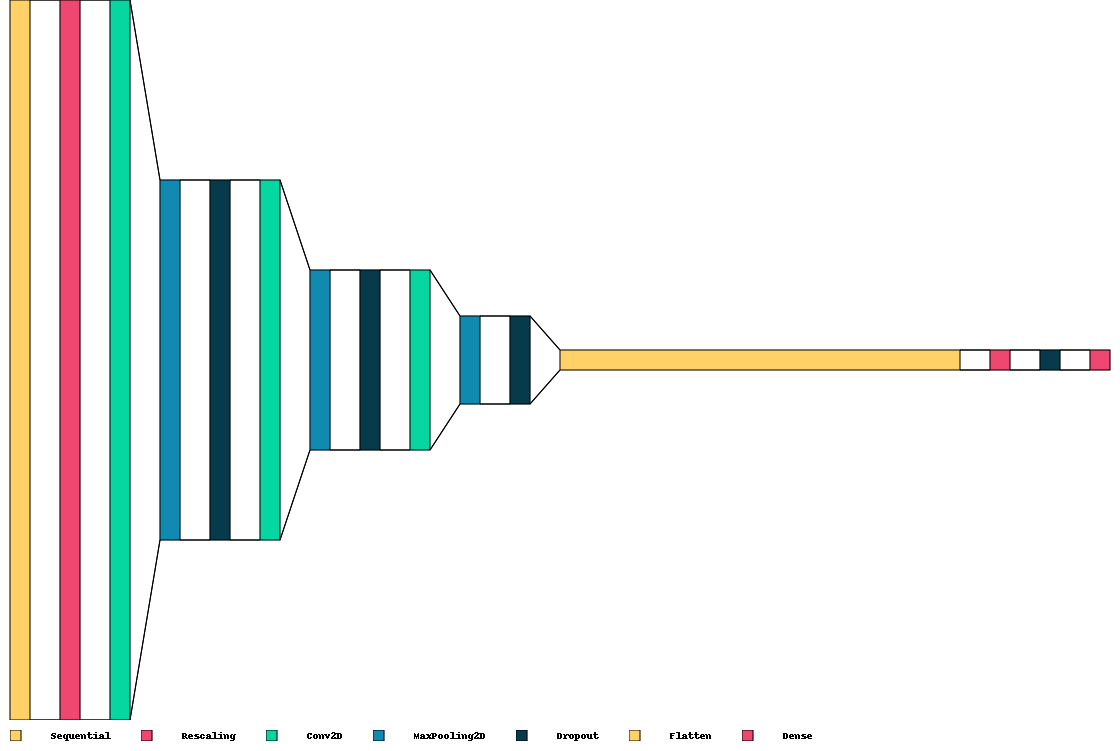

In [ ]:
from IPython.display import clear_output
try:
    import visualkeras
except ImportError:
    !pip install visualkeras
    import visualkeras

clear_output()
visualkeras.layered_view(model, legend=True, draw_volume=False, spacing=30)

`````{admonition} Remark
:class: important
The proposed model can be enhanced through further fine-tuning.
`````

## Early stopping

Early stopping is a way to prevent deep neural networks from overfitting, which means that they learn too much from the training data and fail to generalize to new data. Overfitting can happen when the model is trained for too long and becomes too complex. Early stopping stops the training process before that happens, by monitoring the model's performance on a separate validation data set, which is a part of the data that is not used for training but for checking the model's accuracy. Early stopping works as follows:

- The model is trained for a certain number of iterations, which are also called epochs. In each epoch, the model learns from the training data and updates its weights, which are the values that determine how the model processes the input data and produces the output data.
- After each epoch, the model's accuracy on the validation data is calculated and compared to the previous epochs. The accuracy is a measure of how well the model predicts the correct output for the validation data. The higher the accuracy, the better the model.
- If the accuracy on the validation data improves significantly from one epoch to another, it means that the model is still learning and becoming better. In that case, the training continues and the model's weights are saved as the best weights so far.
- If the accuracy on the validation data does not improve significantly or even decreases from one epoch to another, it means that the model is not learning anymore and becoming worse. In that case, the training is stopped and the best weights that were saved before are used as the final weights for the model.
- The final weights are then used to evaluate the model's performance on a test data set, which is another part of the data that is not used for training or validation but for testing the model's accuracy on new and unseen data.

Early stopping is a simple and effective way to regularize deep neural networks, which means to control their complexity and prevent overfitting. By stopping the training at the right time, early stopping can improve the model's adaptability and generalization ability, which are important for real-world applications {cite:p}`naushad2021deep,dastour2023comparison`.

## Fitting the model

The [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) function serves as a callback within the Keras framework, designed to halt the training of a model based on specified conditions. This callback is typically invoked at predefined intervals during the training process, such as the conclusion of each epoch. Its primary functionality lies in monitoring a designated metric, such as validation accuracy or loss, and assessing whether improvement has occurred. If there is no improvement observed over a predetermined number of epochs, known as the patience, the training process is terminated. Additionally, the EarlyStopping function has the capability to restore the model weights to the optimal configuration obtained prior to the cessation of training.

The instantiation of the EarlyStopping callback is achieved through the code `tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)`. This code creates an object equipped to interrupt the training process when the monitored metric ceases to exhibit improvement. The callback is characterized by two parameters: patience and restore_best_weights. The patience parameter dictates the number of consecutive epochs without improvement that triggers the termination of training. In this instance, a patience value of 5 implies that training halts if the metric fails to improve for five successive epochs. The restore_best_weights parameter determines whether the model should revert to the weights associated with the epoch featuring the optimal metric value. When set to True, the model reinstates the best weights; when set to False, the weights from the final epoch are retained. Notably, in the provided code, restore_best_weights is set to True, signifying the preference for utilizing the best weights upon the conclusion of training. This strategic utilization of the EarlyStopping callback contributes to the model's resilience against overfitting tendencies and enhances its overall performance, as discussed in {cite:p}`TensorFlowDocumentation`.

In [8]:
import tensorflow as tf

# Compile the model
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics= ['accuracy'])

# Train the model using the training and validation datasets with the custom callback
history = model.fit(train_ds, validation_data=val_ds, epochs= 100, verbose = 2,
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience= 5, restore_best_weights=True)])

Epoch 1/100
7/7 - 17s - loss: 4.7085 - accuracy: 0.6183 - val_loss: 3.0626 - val_accuracy: 0.7100 - 17s/epoch - 2s/step
Epoch 2/100
7/7 - 1s - loss: 2.8164 - accuracy: 0.7034 - val_loss: 2.4934 - val_accuracy: 0.7500 - 746ms/epoch - 107ms/step
Epoch 3/100
7/7 - 1s - loss: 2.3255 - accuracy: 0.7559 - val_loss: 2.0678 - val_accuracy: 0.7500 - 726ms/epoch - 104ms/step
Epoch 4/100
7/7 - 1s - loss: 1.9435 - accuracy: 0.7559 - val_loss: 1.7574 - val_accuracy: 0.7500 - 745ms/epoch - 106ms/step
Epoch 5/100
7/7 - 1s - loss: 1.6615 - accuracy: 0.7559 - val_loss: 1.5080 - val_accuracy: 0.7500 - 739ms/epoch - 106ms/step
Epoch 6/100
7/7 - 1s - loss: 1.4321 - accuracy: 0.7559 - val_loss: 1.3277 - val_accuracy: 0.7500 - 746ms/epoch - 107ms/step
Epoch 7/100
7/7 - 1s - loss: 1.2684 - accuracy: 0.7559 - val_loss: 1.1823 - val_accuracy: 0.7500 - 715ms/epoch - 102ms/step
Epoch 8/100
7/7 - 1s - loss: 1.1349 - accuracy: 0.7672 - val_loss: 1.0733 - val_accuracy: 0.8000 - 725ms/epoch - 104ms/step
Epoch 9/100


The output represents the training progress of a neural network model over 52 epochs, each involving a complete iteration through the training dataset. Key performance metrics such as loss and accuracy for both the training and validation datasets are reported after each epoch. Additionally, the time taken for each epoch and step is provided.

In the initial epoch (Epoch 1/100), the training set exhibited a loss of 4.7085 and an accuracy of 0.6183, while the validation set had a loss of 3.0626 and an accuracy of 0.7100. Subsequent epochs show the evolution of these metrics, reflecting the model's adjustment to the training data.

Notable observations:
- The model's performance on the training set, indicated by accuracy, appears to stabilize around 0.95 after the initial epochs.
- Validation accuracy exhibits improvement over the epochs, reaching 0.9800 in the later stages.
- The loss values, both for training and validation, decrease over time, indicating improved convergence of the model.

The reported times (e.g., "17s/epoch," "2s/step") provide insights into the computational efficiency of the training process. The time per epoch includes the time taken for each training epoch, while the time per step represents the time taken for each batch processing step within an epoch.

The training process utilized an EarlyStopping callback, as evident from the code provided earlier. This callback is designed to monitor the validation loss and halt training if no improvement is observed for a specified number of epochs (patience). The best weights are then restored to enhance the model's performance.

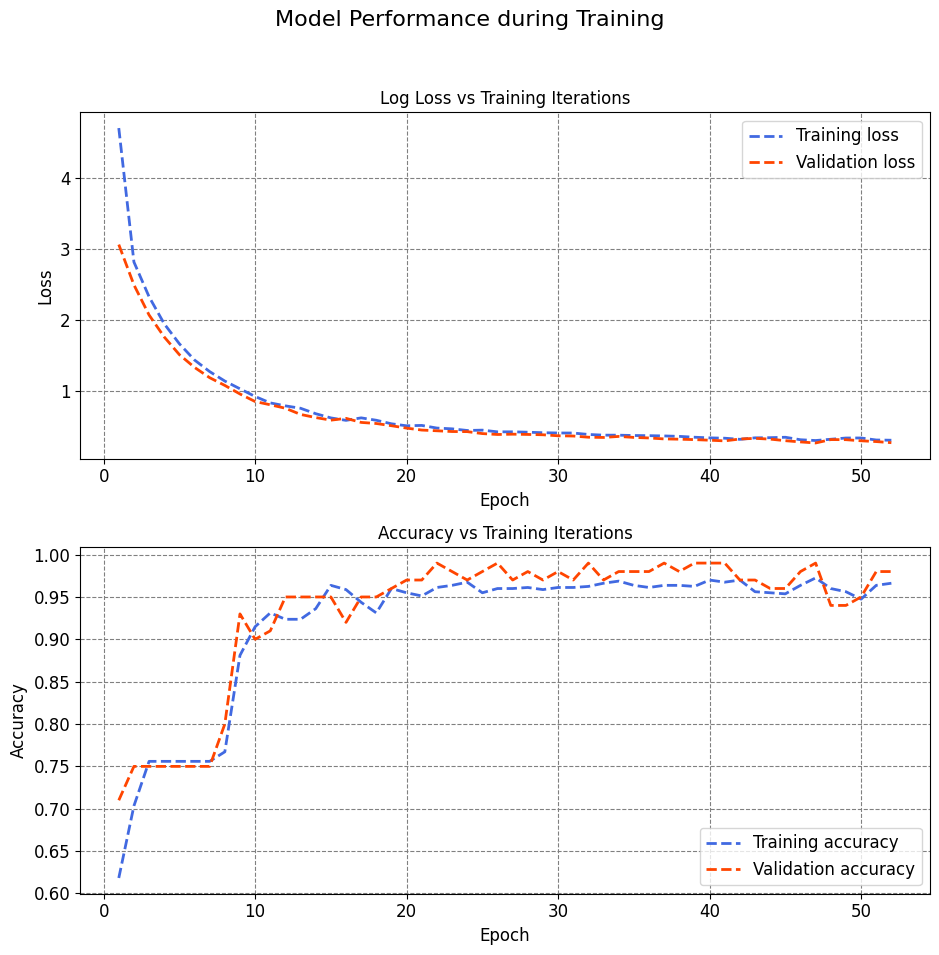

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9.5, 10))

# Define style colors
style_colors = ['RoyalBlue', 'OrangeRed']

# Plot labels and titles
plot_labels = ['Loss', 'Accuracy']
plot_titles = ['Log Loss vs Training Iterations', 'Accuracy vs Training Iterations']

# Loop through plots
for i, (label, title) in enumerate(zip(plot_labels, plot_titles)):
    # Plot training and testing metrics from the history file
    axes[i].plot(range(1, len(history.history['loss']) + 1), history.history['loss'] if label == 'Loss' else history.history['accuracy'],
                 label="Training " + label.lower(), color=style_colors[0], linestyle='dashed', linewidth=2)

    axes[i].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'] if label == 'Loss' else history.history['val_accuracy'],
                 label="Validation " + label.lower(), color=style_colors[1], linestyle='dashed', linewidth=2)

    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel(label)
    axes[i].legend(fontsize = 12)
    axes[i].set_title(title)

# Add a common title
fig.suptitle("Model Performance during Training", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The results show the loss and accuracy of the model on the training and validation datasets for each epoch. The loss is a measure of how much the model's predictions differ from the true labels, and the accuracy is a measure of how many of the model's predictions are correct. The lower the loss and the higher the accuracy, the better the model. The results also show the time taken for each epoch and each step, which is a batch of data processed by the model.

The results indicate that the model is improving over time, as the loss decreases and the accuracy increases on both the training and validation datasets. However, the improvement is not consistent or significant after some point, which suggests that the model is reaching its optimal performance and may start to overfit if trained further. Overfitting is a situation where the model learns too much from the training data and fails to generalize to new data.

To prevent overfitting, you used the EarlyStopping callback, which is a function that can stop the training when a monitored metric has stopped improving. You set the patience argument to 5, which means that the training will stop if the metric does not improve for 5 consecutive epochs. You also set the restore_best_weights argument to True, which means that the model will use the best weights that were obtained before the training stopped. You monitored the validation loss as the metric, which is the loss on the validation dataset.

The results show that the training stopped at epoch 52, because the validation loss did not improve for 5 epochs. The best validation loss was 0.2601, which was achieved at epoch 47. The model used the weights from that epoch as the final weights. The validation accuracy at that epoch was 0.9900, which means that the model correctly predicted 99% of the validation images. The training loss and accuracy at that epoch were 0.2947 and 0.9725, respectively.

In [25]:
import numpy as np
import pandas as pd

# Define Metric Names (mapping from metric keys to more descriptive names)
Metrics_Names = {'loss': 'Loss', 'accuracy': 'Accuracy', 'mae': 'MAE', 'mse': 'MSE', 'recall': 'Recall'}

# Filter and modify history keys
Validation_Table = [key for key in history.history.keys() if 'val_' in key]
Train_Table = [key for key in history.history.keys() if key not in Validation_Table]

# Create DataFrames for validation and training metrics
Validation_Table = pd.DataFrame({key.replace('val_', ''): history.history[key] for key in Validation_Table})
Train_Table = pd.DataFrame({key: history.history[key] for key in Train_Table})

# Rename columns and add Iteration column
def modify_table(df):
    df = df.rename(columns=Metrics_Names)
    df['Iteration'] = np.arange(df.shape[0])
    return df[['Iteration'] + sorted(df.columns[:-1])]

Validation_Table = modify_table(Validation_Table)
Train_Table = modify_table(Train_Table)

# Evaluate and format scores for train, validation, and test datasets
def evaluate_and_format(model, dataset, batch_size):
    scores = model.evaluate(dataset, batch_size=batch_size, verbose=0)
    scores_df = pd.DataFrame([scores], columns=model.metrics_names)
    return scores_df

# Calculate and format scores for the train, validation, and test datasets
score_train = evaluate_and_format(model, train_ds, batch_size)
score_val = evaluate_and_format(model, val_ds, batch_size)
score_test = evaluate_and_format(model, test_ds, batch_size)

# Concatenate and display scores in a table
score = pd.concat([score_train, score_val, score_test], axis=0, ignore_index=True)
score.index = ['Train', 'Validation', 'Test']
score.rename(columns=Metrics_Names, inplace=True)

# Display the score table
display(score.style.format({'Loss': '{:.5f}', 'Accuracy': '{:.5f}'}))

,Loss,Accuracy
Train,0.30523,0.96496
Validation,0.26013,0.99000
Test,0.31243,0.98000


The results show the loss and accuracy of the model on the train, validation, and test datasets. The loss is a measure of how much the model's predictions differ from the true labels, and the accuracy is a measure of how many of the model's predictions are correct. The lower the loss and the higher the accuracy, the better the model.

The results indicate that the model has a high performance on all the datasets, as the loss is low and the accuracy is high. The model performs slightly better on the validation and test datasets than on the train dataset, which suggests that the model is not overfitting and can generalize well to new data. The model performs the best on the validation dataset, which has the lowest loss and the highest accuracy. The model performs slightly worse on the test dataset, which has a higher loss and a lower accuracy than the validation dataset, but still very close. The test dataset is the most important dataset to evaluate the model's performance, as it represents the real-world data that the model will encounter. The results show that the model can handle different kinds of images and classify them correctly into fire and non-fire classes.

In [26]:
from IPython.display import clear_output

# Function to create and display a confusion matrix using seaborn heatmap
def create_confusion_matrix(model, dataset):
    y_true = []
    y_pred = []

    # Generate predictions
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        y_pred.extend(model.predict(images).argmax(axis=1))

    # Calculate the confusion matrix
    confusion = tf.math.confusion_matrix(y_true, y_pred)

    return confusion

# Create confusion matrices for Train, Validation, and Test sets
CM_train = create_confusion_matrix(model, train_ds)
CM_val = create_confusion_matrix(model, val_ds)
CM_test = create_confusion_matrix(model, test_ds)
clear_output()

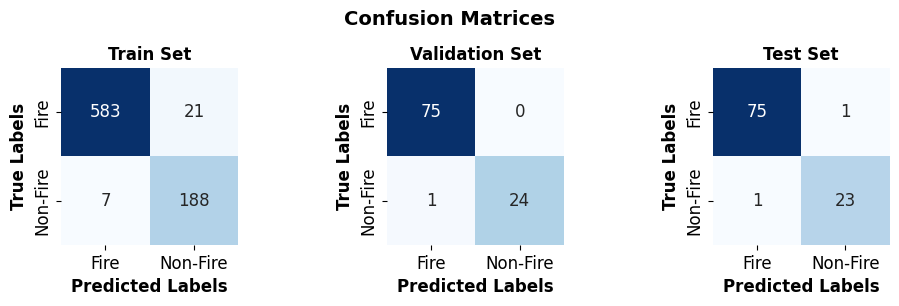

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(ax, confusion_matrix, dataset_name, num2label_dict = num2label_dict):
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=num2label_dict.values(), yticklabels= num2label_dict.values(), ax=ax,
                annot_kws={"fontsize": 12})
    ax.set(title=dataset_name, xlabel='Predicted Labels', ylabel='True Labels')
    for label in [ax.title, ax.xaxis.label, ax.yaxis.label]:
        label.set_fontweight('bold')
    ax.grid(False)

fig, axes = plt.subplots(1, 3, figsize=(9.5, 3))
fig.suptitle('Confusion Matrices', fontsize=14, weight='bold')

# Assuming you have CM_train, CM_val, and CM_test defined
for ax, confusion_matrix, title in zip(axes, [CM_train, CM_val, CM_test], ['Train Set', 'Validation Set', 'Test Set']):
    plot_confusion_matrix(ax, confusion_matrix, title)

plt.tight_layout()
plt.subplots_adjust(wspace= .5)

In [28]:
# print(num2label_dict)
# CM_train, CM_val, CM_test

{0: 'Fire', 1: 'Non-Fire'}


(<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[583,  21],
        [  7, 188]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[75,  0],
        [ 1, 24]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[75,  1],
        [ 1, 23]], dtype=int32)>)

The results show the confusion matrices of the model on the train, validation, and test datasets. A confusion matrix is a table that shows how well the model predicts the correct class for each input image. The rows of the matrix represent the true classes, and the columns represent the predicted classes. The diagonal elements of the matrix show the number of images that were correctly classified, and the off-diagonal elements show the number of images that were misclassified. The higher the diagonal elements and the lower the off-diagonal elements, the better the model. The results also show the labels of the classes, which are fire and non-fire. Here is an interpretation of the results:

- The first confusion matrix is for the train dataset, which has 799 images. The model correctly predicted 583 fire images and 188 non-fire images, which are the diagonal elements. The model misclassified 21 fire images as non-fire images, and 7 non-fire images as fire images, which are the off-diagonal elements. The model's accuracy on the train dataset is (583 + 188) / 799 = 0.9649, which means that the model correctly predicted 96.49% of the train images.
- The second confusion matrix is for the validation dataset, which has 100 images. The model correctly predicted 75 fire images and 24 non-fire images, which are the diagonal elements. The model misclassified 1 fire image as non-fire image, and 0 non-fire images as fire images, which are the off-diagonal elements. The model's accuracy on the validation dataset is (75 + 24) / 100 = 0.9900, which means that the model correctly predicted 99.00% of the validation images.
- The third confusion matrix is for the test dataset, which has 100 images. The model correctly predicted 75 fire images and 23 non-fire images, which are the diagonal elements. The model misclassified 1 fire image as non-fire image, and 1 non-fire image as fire image, which are the off-diagonal elements. The model's accuracy on the test dataset is (75 + 23) / 100 = 0.9800, which means that the model correctly predicted 98.00% of the test images.

The results indicate that the model has a high performance on all the datasets, as the confusion matrices show a high number of correct predictions and a low number of incorrect predictions. The model performs slightly better on the validation dataset than on the train and test datasets, which suggests that the model is not overfitting and can generalize well to new data. The test dataset is the most important dataset to evaluate the model's performance, as it represents the real-world data that the model will encounter. The results show that the model can handle different kinds of images and classify them correctly into fire and non-fire classes.